In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import collections
import tensorflow as tf
sys.path.append('./*')
sys.path=list(set(sys.path))

import keras
from keras import backend as K
from keras.optimizers import RMSprop, Adam, SGD, Adadelta
from keras.utils import to_categorical, plot_model
from keras.models import Model
from keras.layers import (Input, Dense, Lambda, Flatten, Reshape,
                          BatchNormalization, Activation, Dropout, concatenate)
from keras.losses import mse, binary_crossentropy, categorical_crossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tnrange

from model import keras_models
from model.keras_models import create_dense_layers, inst_layers, sampling
from module_DTI import my_dataset
from module_DTI.default_load import *
from module_DTI.utils import plot_mse_mae_history, plot_roc_curve, plot_epoch_acc_loss, get_auroc

config = collections.namedtuple('config', ['Dataset'])
dict_directories = {'dir_ROOT': './dataset/final', }
dict_directories.update({
    'DTI_adjmat': dict_directories['dir_ROOT'] + '/drug-target_mat.tsv',
    'drug': dict_directories['dir_ROOT'] + '/drug_descriptor.tsv',
    'target': dict_directories['dir_ROOT'] + '/protein_descriptor.tsv'
})
config_Dataset = {
        'dict_directories': dict_directories,
        'neg_to_pos_ratio': 1,
        'split_ratio': 0.8,
        'pos_filename': 'pos_sample.txt',
        'neg_filename': 'neg_sample_1.txt',
        'unlabel_to_label_ratio':10
}
save_path='./model/model_saved/'
checkpoint_path='./model/model_checkpoints/'
config.Dataset = config_Dataset


Using TensorFlow backend.


In [2]:
pretrained_pair_ae=keras.models.load_model(save_path+'pair_dim500_e100_b100.hdf')
pretrained_pair_layer=pretrained_pair_ae.layers[1].layers[1:]
drug_target_intput=Input(shape=(1627,),name='DT_input')
drug_target_vector=inst_layers(pretrained_pair_layer,drug_target_intput)
M1=Model(inputs=drug_target_intput,outputs=drug_target_vector)

In [3]:
config,train_x,train_y,test_x,test_y,n_train,n_test,DTI,unlabeled_data=common_code_all(config,unlabel=True)

--------------------------------------------------------
Load DTI data.
# of drug: 3645
# of target: 1643

# of drugs: 4170
# of features of a drug: 190

# of targets: 2103
# of features of a target: 1437

# of drug-target interactions: 9592

--------------------------------------------------------
Load existing positive & negative sample files.
# of positive samples: 9592
# of features of a positive sample: 1627

# of negative samples: 9592
# of features of a negative sample: 1627

--------------------------------------------------------
Split train & test set from samples.
Your split ratio (train/total): 0.8

--------------------------------------------------------
Load existing unlabel sample file.
Your ratio (unlabel/label): 10

--------------------------------------------------------
Complete loading all default dataset & variables.


In [4]:
pre_unlabel_train=M1.predict(unlabeled_data)

N_label: tot
---------------
neg_sample_1.txt
Load existing positive & negative sample files.
# of positive samples: 9592
# of features of a positive sample: 1627

# of negative samples: 9592
# of features of a negative sample: 1627

Split train & test set from samples.
Your split ratio (train/total): 0.8

--------------------------------------------------------
(25346, 500)
(172640, 500)
Acc: 79.1037
AUROC: 0.8438
TPR: 0.8264721208963002
TNR: 0.7556018759770714
PRE: 0.7717761557177616
F1: 0.7981882234524409


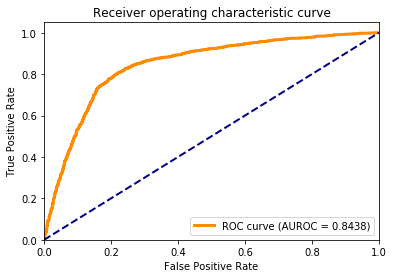

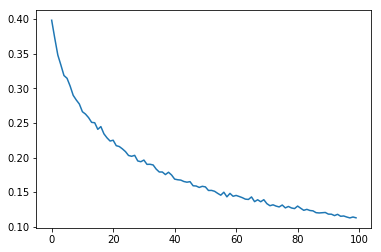

---------------
neg_sample_2.txt
Load existing positive & negative sample files.
# of positive samples: 9592
# of features of a positive sample: 1627

# of negative samples: 9592
# of features of a negative sample: 1627

Split train & test set from samples.
Your split ratio (train/total): 0.8

--------------------------------------------------------


In [ ]:
N_label='tot'
name_l='m3_pre_semi'
test='test1'
save='on'
semi_on='on'
epochs=100
batch_size=200 #166*4#, 17264 train/test scheme
input_dim=500
n=config_Dataset['unlabel_to_label_ratio']
print('N_label: '+str(N_label))
acc_list=[]
auroc_list=[]
TPR_list=[]
TNR_list=[]
PRE_list=[]
F1_list=[]

top_pos=5000
top_neg=5000
repmat_pos=np.tile(np.array([0,1]),(top_pos,1))
repmat_neg=np.tile(np.array([1,0]),(top_neg,1))
for ii in range(5):
    print('---------------')

    neg_st=str(ii+1)
    l_best_model_filename=checkpoint_path+str(N_label)+'_'+neg_st+'_'+name_l
    config.Dataset['neg_filename']='neg_sample_'+neg_st+'.txt'
    print(config.Dataset['neg_filename'])
    train_x,train_y,test_x,test_y=common_code_train_test_loading(config,DTI)

    if N_label=='tot':
        label_train_x=M1.predict(train_x)
        label_train_y=train_y
    else:
        j,k=0,0
        _ind=[]
        for ind,ele in enumerate(train_y):
            if list(ele)==[1,0] and j!=N_label//2:
                j+=1
                _ind.append(ind)
            elif list(ele)==[0,1] and k!=N_label//2:
                k+=1
                _ind.append(ind)
        label_train_x=M1.predict(train_x[_ind,:])
        label_train_y=train_y[_ind,:]
    label_test_x=M1.predict(test_x)
    label_test_y=test_y 
    if semi_on=='on':
        unlabel_train_x=pre_unlabel_train


    classifier_layers = [
        create_dense_layers(stage='classifier_1', units=300, 
                            activation='relu', dropout=0.2, 
                            batch_normalization='off'),
        create_dense_layers(stage='classifier_2', units=100, 
                            activation='relu', dropout=0.2, 
                            batch_normalization='off'),
        Dense(2, name='classifier_3'),
        Activation('softmax', name='y_predicted')
    ]

    pretraining_layers=[
        Dense(500)
    ]
    x_in =Input(shape=(input_dim,), name='x_Input')
    h = inst_layers(classifier_layers[0:2],x_in)
    x_in_hat=Dense(units=500,name='x_output')(h)
    y_output = inst_layers(classifier_layers,x_in)
    optimizer_l = Adam()
    optimizer_u = Adam()

    pretrain_model=Model(x_in,x_in_hat)
    pretrain_model.compile(optimizer=optimizer_u,loss='mse')
    pretrain_model.fit(pre_unlabel_train,pre_unlabel_train,epochs=10,batch_size=200,verbose=0)
    
    classifier=Model(x_in,y_output)
    classifier.compile(optimizer=optimizer_l,loss='categorical_crossentropy')
    classifier.fit(label_train_x,label_train_y,epochs=10,batch_size=200,verbose=0)
    
    finetune_model=Model(x_in,[x_in_hat,y_output])
    finetune_model.compile(optimizer=optimizer_l,
                      loss={
                          'x_output':'mse',
                          'y_predicted':'categorical_crossentropy'
                      })

    history = []
    l=[0]
    checkpoint_cls=1000
    if semi_on=='on':
        semi_train_x=label_train_x
        semi_train_y=label_train_y

    for epoch in range(epochs):
        index = np.arange(len(label_train_x))
        np.random.shuffle(index)
        batches = len(label_train_x) // batch_size
        for i in range(batches):
            index_range =  index[i * batch_size:(i+1) * batch_size]
            loss = finetune_model.train_on_batch(
                x=[label_train_x[index_range]],
                y={'x_output':label_train_x[index_range],
                   'y_predicted': label_train_y[index_range]}
            )
        l = finetune_model.evaluate(
            x=[label_train_x],
            y={'x_output':label_train_x,
               'y_predicted': label_train_y},
            verbose=2)
        if semi_on=='on':
            if epoch>=10:
                u_pred = classifier.predict(x=[unlabel_train_x])
                top_ind=np.transpose(u_pred)[0].argsort()
    #             pos_top_ind=top_ind[:top_pos*(epoch-2)]
    #             neg_top_ind=top_ind[-top_neg*(epoch-2):]
    #             repmat_pos=np.tile(np.array([0,1]),(top_pos*(epoch-2),1))
    #             repmat_neg=np.tile(np.array([1,0]),(top_neg*(epoch-2),1))
                pos_top_ind=top_ind[:top_pos]
                neg_top_ind=top_ind[-top_neg:]

                semi_train_x=np.append(label_train_x,unlabel_train_x[np.concatenate((pos_top_ind,neg_top_ind))],axis=0)
                semi_train_y=np.append(label_train_y,repmat_pos,axis=0)
                semi_train_y=np.append(semi_train_y,repmat_neg,axis=0)
    #             semi_unlabel=np.delete(unlabel_train_x,np.append(pos_top_ind,neg_top_ind),axis=0)
        if save=='on' and epoch>=5 and l[2]<checkpoint_cls:
                checkpoint_cls=l[2]
                classifier.save(l_best_model_filename+'.h5')
#         print(l)
        history.append(l) 
    if semi_on=='on':
        print(np.shape(semi_train_x))
        print(np.shape(unlabel_train_x))

    classifier.load_weights(l_best_model_filename+'.h5')
    y_pred = to_categorical(np.argmax(classifier.predict(label_test_x), axis=-1), 2)

    auroc=get_auroc(classifier,label_test_x,label_test_y)
    score = accuracy_score(label_test_y, y_pred)
    tn, fp, fn, tp=confusion_matrix(np.argmax(label_test_y, axis=1), np.argmax(y_pred, axis=1)).ravel()
    TPR=tp/(tp+fn)
    TNR=tn/(tn+fp)
    PRE=tp/(tp+fp)
    F1=2*PRE*TPR/(PRE+TPR)
    print('Acc: '+str(round(score*100,4)))
    print('AUROC: ' + str(round(auroc,4)))
    print('TPR: '+str(TPR))
    print('TNR: '+str(TNR))
    print('PRE: '+str(PRE))
    print('F1: '+str(F1))
    auroc_list.append(str(round(auroc,4)))
    acc_list.append(str(round(score*100,4)))
    TPR_list.append(str(round(TPR,4)))
    TNR_list.append(str(round(TNR,4)))
    PRE_list.append(str(round(PRE,4)))
    F1_list.append(str(round(F1,4)))

    plot_roc_curve(classifier,label_test_x,label_test_y)
    df = pd.DataFrame(history, columns=['total','accuracy','classifier_loss'])
    df['classifier_loss'].plot()
    plt.show()  

if ii==4:
    with open(l_best_model_filename+'_'+test+'.txt','w') as f:
        f.write('acc\n'+'\n'.join(acc_list))
        f.write('\nauroc\n'+'\n'.join(auroc_list))
        f.write('\nTPR\n'+'\n'.join(TPR_list))
        f.write('\nTNR\n'+'\n'.join(TNR_list))
        f.write('\nPRE\n'+'\n'.join(PRE_list))
    print('--------------------finish---------------------------')    

In [ ]:
def loop_self_training(classifier,x,y,unlabel_data,top_pos,top_neg,repmat_pos,repmat_neg):
    u_pred = classifier.predict(unlabel_data)
    top_ind=np.transpose(u_pred)[0].argsort()
    pos_top_ind=top_ind[:top_pos]
    neg_top_ind=top_ind[-top_neg:]
    semi_train_x=np.append(x,unlabel_data[np.concatenate((pos_top_ind,neg_top_ind))],axis=0)
    semi_train_y=np.append(y,np.concatenate((repmat_pos,repmat_neg)),axis=0)
    semi_unlabel_data=np.delete(unlabel_data,np.append(pos_top_ind,neg_top_ind),axis=0)
    return semi_train_x,semi_train_y,semi_unlabel_data